# Investigating the Covid Pandemic Impacts on the Gross Domestic Products of G20 Nations

## Introduction

The International Monetary Fund keeps data on key economic indicators for countries around the world. Our group will use this data to investigate the effect the Covid pandemic had on the Gross Domestic Product (GDP) per capita of G20 countries. We will use the following variables to predict GDP per capita: Volume of Goods and Services imported and exported, Inflation, and Employment. We will train all the data on the years from 2010 to 2019 to yield a regression that will predict GDP per capita for 2020, 2021, and 2023. We will then compare our predicted values with the actual values in the data for 2020, 2021, 2022, and 2023, the “Covid years.”

## Preliminary Exploratory Data Analysis

The free dataset from the International Monetary Fund was downloaded from their offical website, saved into our GitHub repository, and read online into this proposal. The dataset was then wrangled to only contain data relevant to our project, the specific variables and observations are identified in our Methods section below. Additionally, the dataset was tidied following the DSCI 100's 3 criterion for tidy data. A summary table and visualization using training data is also shown below.

In [92]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)

In [94]:
G20_economic_data <- read_csv("https://raw.githubusercontent.com/mparhar1/DSCI-100-Group-48-Project/main/WEOApri23G20.csv")
colnames(G20_economic_data) <- make.names(colnames(G20_economic_data), unique = TRUE)

head(G20_economic_data, n=3)

Rows: 836 Columns: 59
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (46): ISO, WEO Subject Code, Country, Subject Descriptor, Subject Notes,...
dbl  (2): WEO Country Code, Estimates Start After

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


WEO.Country.Code,ISO,WEO.Subject.Code,Country,Subject.Descriptor,Subject.Notes,Units,Scale,Country.Series.specific.Notes,X1980,⋯,X2020,X2021,X2022,X2023,X2024,X2025,X2026,X2027,X2028,Estimates.Start.After
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
213,ARG,NGDP_R,Argentina,"Gross domestic product, constant prices","Expressed in billions of national currency units; the base year is country-specific. Expenditure-based GDP is total final expenditures at purchasers' prices (including the f.o.b. value of exports of goods and services), less the f.o.b. value of imports of goods and services. [SNA 1993]",National currency,Billions,Source: National Statistics Office Latest actual data: 2021 National accounts manual used: System of National Accounts (SNA) 2008 GDP valuation: Market prices Reporting in calendar year: Yes Start/end months of reporting year: January/December Base year: 2004 Chain-weighted: No Primary domestic currency: Argentine peso Data last updated: 03/2023,357.389,⋯,624.295,689.211,725.346,726.797,741.333,756.161,771.287,786.714,802.448,2021
213,ARG,NGDP_RPCH,Argentina,"Gross domestic product, constant prices","Annual percentages of constant price GDP are year-on-year changes; the base year is country-specific. Expenditure-based GDP is total final expenditures at purchasers' prices (including the f.o.b. value of exports of goods and services), less the f.o.b. value of imports of goods and services. [SNA 1993]",Percent change,NA,"See notes for: Gross domestic product, constant prices (National currency).",0.7,⋯,-9.943,10.398,5.243,0.2,2,2,2,2,2,2021
213,ARG,NGDP,Argentina,"Gross domestic product, current prices","Expressed in billions of national currency units. Expenditure-based GDP is total final expenditures at purchasers' prices (including the f.o.b. value of exports of goods and services), less the f.o.b. value of imports of goods and services. [SNA 1993]",National currency,Billions,Source: National Statistics Office Latest actual data: 2021 National accounts manual used: System of National Accounts (SNA) 2008 GDP valuation: Market prices Reporting in calendar year: Yes Start/end months of reporting year: January/December Base year: 2004 Chain-weighted: No Primary domestic currency: Argentine peso Data last updated: 03/2023,--,⋯,27481.440,46282.070,"82,650.24","164,655.09","268,792.37","403,024.96","584,085.98","817,219.74","1,104,151.70",2021


In [95]:
tidy_G20_economic_data <- G20_economic_data |>
    select(Country,
           Subject.Descriptor,
           Units,
           X2010:X2023
          ) |>
    filter(Subject.Descriptor == "Gross domestic product per capita, current prices" & Units == "U.S. dollars" |
           Subject.Descriptor == "Volume of imports of goods and services" |
           Subject.Descriptor == "Volume of exports of goods and services" | 
           Subject.Descriptor == "Inflation, average consumer prices" & Units == "Percent change" |
           Subject.Descriptor == "Unemployment rate" 
          ) |>
    filter(Country != "Argentina" & Country != "Saudi Arabia") |>
    mutate(X2014 = as.numeric(gsub(",","", X2014)),
           X2015 = as.numeric(gsub(",","", X2015)),
           X2016 = as.numeric(gsub(",","", X2016)),
           X2022 = as.numeric(gsub(",","", X2022)),
           X2023 = as.numeric(gsub(",","", X2023)),
          ) |>
    pivot_longer(cols = X2010:X2023,
                 names_to = "Year",
                 values_to = "Metric"
                ) |>
    group_by(Country, Year, Subject.Descriptor) |>
    summarise(Metric = mean(Metric, na.rm = TRUE)) |>
    pivot_wider(names_from = Subject.Descriptor,
                values_from = Metric
               )

colnames(tidy_G20_economic_data) <- make.names(colnames(tidy_G20_economic_data), unique = TRUE)

head(tidy_G20_economic_data)

`summarise()` has grouped output by 'Country', 'Year'. You can override using
the `.groups` argument.


Country,Year,Gross.domestic.product.per.capita..current.prices,Inflation..average.consumer.prices,Unemployment.rate,Volume.of.exports.of.goods.and.services,Volume.of.imports.of.goods.and.services
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Australia,X2010,56579.03,2.863,5.208,5.709,16.142
Australia,X2011,67270.36,3.356,5.083,-0.144,10.557
Australia,X2012,68450.31,1.686,5.233,5.420,6.183
Australia,X2013,65200.37,2.450,5.658,5.890,-2.284
Australia,X2014,61615.05,2.513,6.058,7.010,-1.410
Australia,X2015,51412.25,1.485,6.050,6.319,2.265


Country,mean_gdp
<chr>,<dbl>
Australia,58874.708
Brazil,10727.808
Canada,48066.366
China,7589.821
France,42013.763
Germany,44992.377
India,1654.561
Indonesia,3682.902
Italy,34305.552


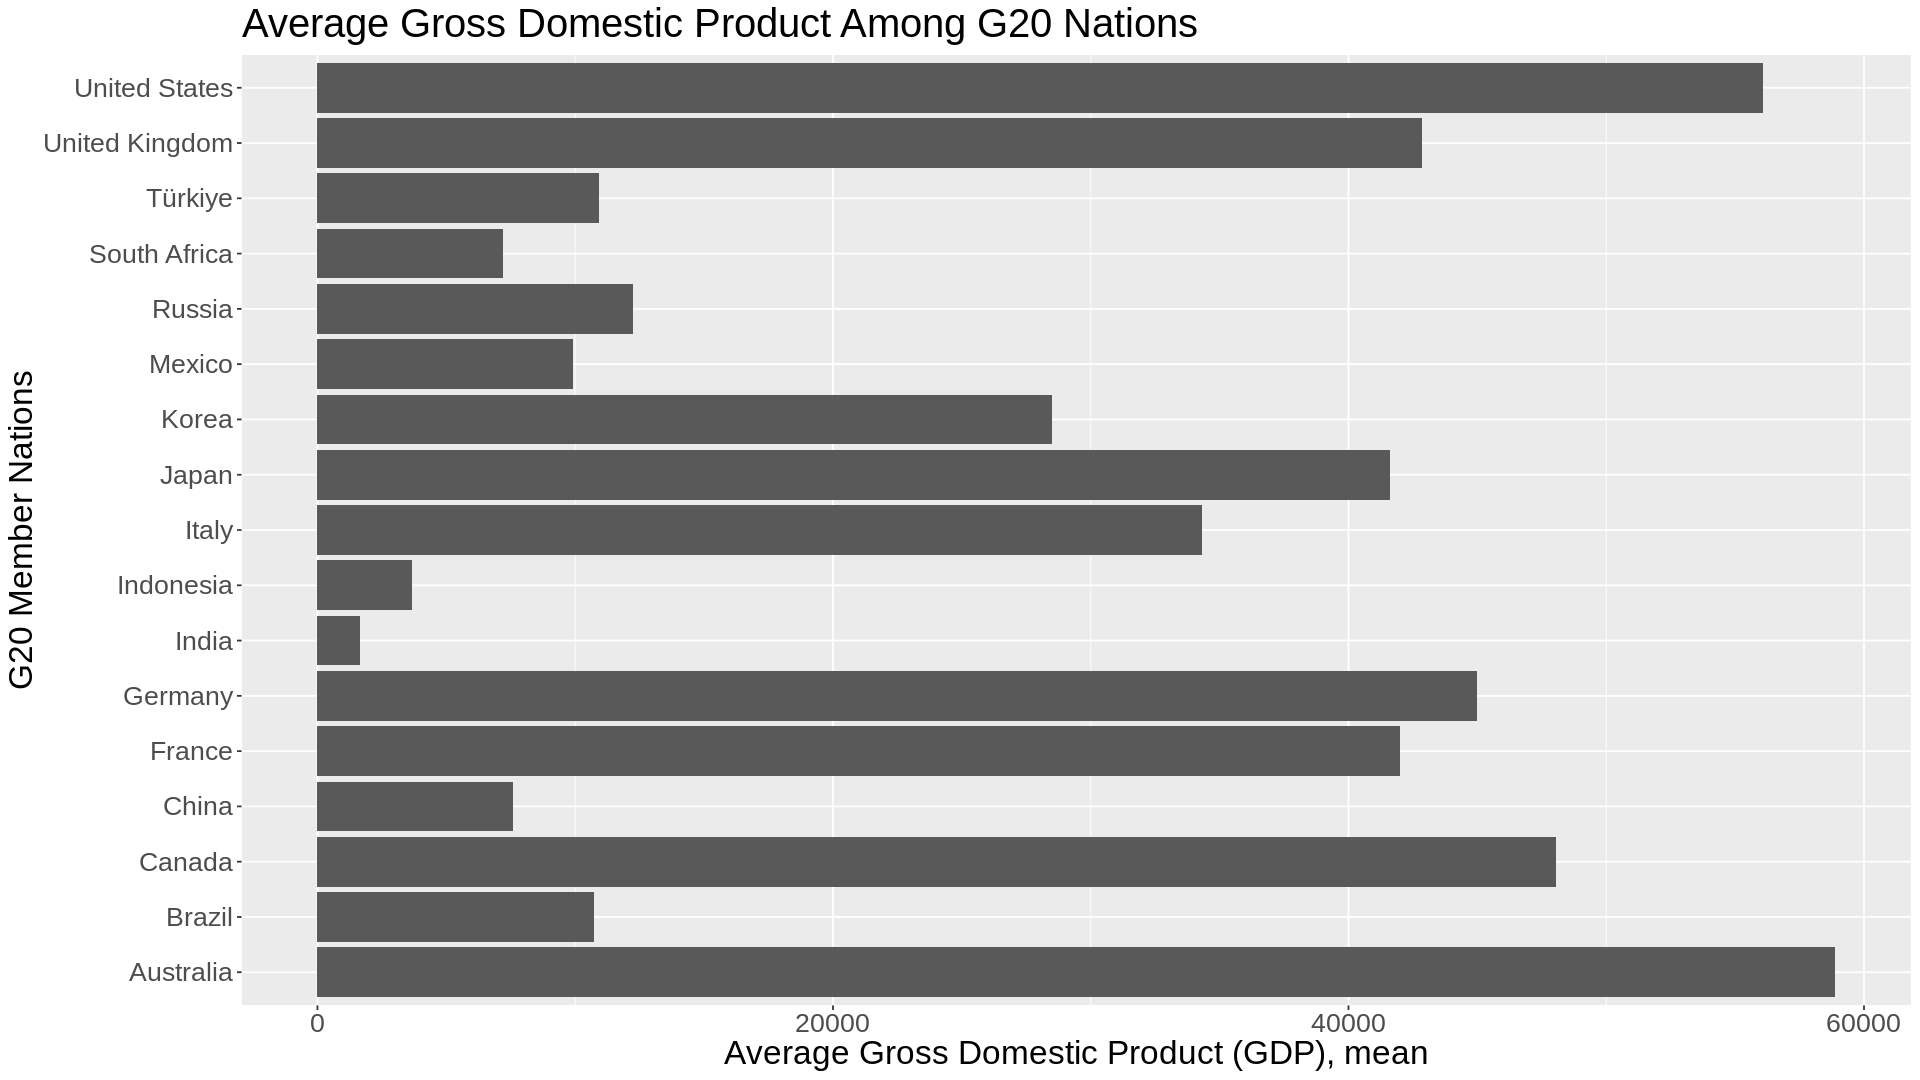

In [111]:
econ_training_data <- tidy_G20_economic_data |>
    filter(Year >= "X2010" & Year <= "X2019")

econ_testing_data <- tidy_G20_economic_data |>
    filter(Year >= "X2020" & Year <= "X2023")

gdp_means_by_nation <- econ_training_data |>
    group_by(Country) |>
    summarise(mean_gdp = mean(Gross.domestic.product.per.capita..current.prices))

options(repr.plot.width = 16, repr.plot.height = 9)
gdp_plot <- ggplot(gdp_means_by_nation, aes(x = Country, y = mean_gdp)) +
    geom_bar(stat = "identity") +
    ggtitle("Average Gross Domestic Product Among G20 Nations") +
    xlab("G20 Member Nations") +
    ylab("Average Gross Domestic Product (GDP), mean") +
    coord_flip() +
    theme(text = element_text(size = 20))

gdp_means_by_nation
gdp_plot

## Methods

The variables we’ll use to predict Gross domestic product per capita (GDP), current prices ($USD) are: volume of imports of goods and services, volume of exports of goods and services, inflation average consumer prices and the variable unemployment; which we will mutate into an employment variable.

To visualize our results we’ll be plotting the data into nineteen separate grids each representing a line graph for its respective country (*note:* the Eurpean Union (EU) is a G20 member but will not be examined as its GDP is more complicated, and Argentina and Saudi Arabia will not be examined as they did not have complete data), with the year as the x-axis and GDP in the y-axis. 

## Expected Outcomes and Significance

We expect to find that the COVID pandemic caused a decrease in GDP per capita of G20 countries. For example, the variable, Volume of Goods and Services imported and exported and Employment, was seen to decline amidst the pandemic. Whilst Inflation has risen, thus consumption lessens, leading to a decrease in GDP per capita.

Our findings provide us a better understanding of the impact of the COVID pandemic. It helps us visualise how necessary each variable is in our way of life. Further, our findings could predict how the economy will be impacted from future devastations, and better prepare us for what is to come.

Some questions could include, whether in this new era, where the world is gradually healing from COVID, could the data used, still be able to predict the GDP of years to come?